In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from glob import glob
%matplotlib inline

In [2]:
folderLoc ='/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/extractedGZ/WINDS/'
fileList = glob(folderLoc + '*_xrr_COARE3p5_2000_withRAIN_2hrMeanVar.nc')

In [3]:
# count = 0
# for fname in fileList:
#     print(fname.lstrip(folderLoc).rstrip('_xrr_COARE3p5_2000_withRAIN_2hrMeanVar.nc'))
#     #_xrr_COARE3p5_2000_2hrMeanVar.nc
#     ds = xr.open_dataset(fname)
#     ds['mean_WVEL'] = np.sqrt(ds['mean_U10N_x'] **2 + ds['mean_U10N_y']**2)
#     selectLabels = ['mean_WVEL', 'mean_WSPD', 'std_WSPD', 
#                     'std_cosWDIR' , 'std_sinWDIR', 
#                     'mean_SST', 'std_SST', 
#                     'mean_AIRT', 'std_AIRT',
#                     'mean_SST - AIRT', 'std_SST - AIRT',
#                     'mean_RELH', 'std_RELH',
#                     'mean_RAIN', 'RAIN']
#     subDS = ds[selectLabels]
#     selectMask = ~np.isnan(subDS['mean_WVEL'].to_numpy())
#     subDS = subDS.isel(TIME=selectMask)
#     stdLabels = ['std_WSPD', 'std_cosWDIR', 'std_sinWDIR', 'std_SST', 'std_AIRT', 'std_SST - AIRT', 'std_RELH']
#     for label in stdLabels:
#         mask = np.isnan(subDS[label].to_numpy())
#         #print(label, np.sum(mask))
#         subDS[label] = xr.where(mask, 0.0, subDS[label])
#     data = subDS.to_dataframe()
#     if count == 0:
#         allDF = data
#     else:
#         allDF = pd.concat([allDF, data])
#     ds.close()
#     count+= 1
            

In [4]:
#allDF

In [5]:
#allDF.to_csv('allData.csv', index=False)

In [6]:
allDF = pd.read_csv('allData.csv')

In [7]:
len(allDF)

12710025

In [8]:
# data = allDF
# data['RAIN_LABEL'] = data['RAIN'].apply(lambda x: 1 if x > 10 else 0)

# # Features to use for classification
# features = ['mean_WSPD', 'mean_SST', 'mean_AIRT', 'mean_SST - AIRT', 'mean_RELH', 'std_WSPD', 'std_cosWDIR', 'std_sinWDIR', 'std_SST', 'std_AIRT', 'std_SST - AIRT', 'std_RELH']

# # Split the dataset into features (X) and target (y)
# X = data[features]
# y = data['RAIN_LABEL']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize and train a RandomForest Classifier
# classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
# classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = classifier.predict(X_test)

# # Evaluate the classifier performance
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [9]:
data = allDF
data['RAIN_LABEL'] = data['mean_RAIN'].apply(lambda x: 1 if x > 1 else 0)

# Features to use for classification
features = ['mean_WSPD', 'mean_SST', 'mean_AIRT', 'mean_SST - AIRT', 'mean_RELH', 'std_WSPD', 'std_cosWDIR', 'std_sinWDIR', 'std_SST', 'std_AIRT', 'std_SST - AIRT', 'std_RELH']

# Split the dataset into features (X) and target (y)
X = data[features]
y = data['RAIN_LABEL']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForest Classifier
classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9995869402302513

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2471093
           1       1.00      0.99      0.99     70912

    accuracy                           1.00   2542005
   macro avg       1.00      0.99      1.00   2542005
weighted avg       1.00      1.00      1.00   2542005



In [10]:
train_acc = accuracy_score(y_train, classifier.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
#If train accuracy ≫ test accuracy → Overfitting

Train Accuracy: 1.0000
Test Accuracy: 0.9996


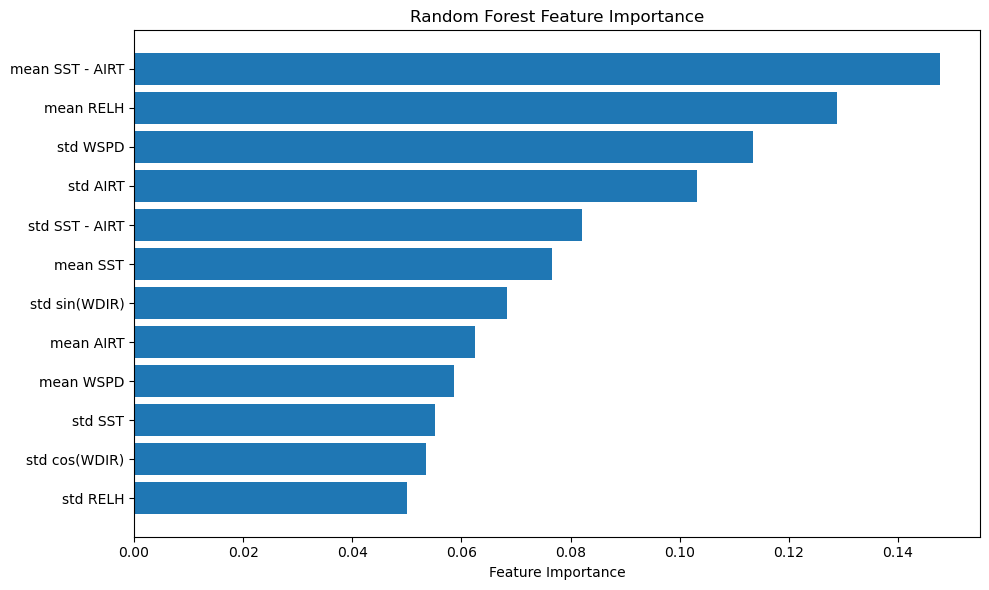

In [25]:
importances = classifier.feature_importances_
features = X_train.columns  # Or supply your feature names list

# Replace underscores with spaces in feature names
pretty_features = [f.replace('_', ' ') for f in features]
pretty_features = [f.replace('sinWDIR', 'sin(WDIR)') for f in pretty_features]
pretty_features = [f.replace('cosWDIR', 'cos(WDIR)') for f in pretty_features]
    

# Create a DataFrame for better plotting
feat_imp_df = pd.DataFrame({'Feature': pretty_features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('RainFlagRandomforestFeatureImportance.pdf', dpi=100)

In [12]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'class_weight': ['balanced']
# }

# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=42),
#     param_grid,
#     cv=3,  # 3-fold cross-validation
#     scoring='f1_macro',  # Balanced F1 score across classes
#     n_jobs=-1,
#     verbose=2
# )

# grid_search.fit(X_train, y_train)
# print("Best parameters:", grid_search.best_params_)
# best_model = grid_search.best_estimator_

In [13]:

# train_acc = accuracy_score(y_train, best_model.predict(X_train))
# test_acc = accuracy_score(y_test, y_pred)

# print(f"Train Accuracy: {train_acc:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}")
# #If train accuracy ≫ test accuracy → Overfitting

In [14]:
falsePos = np.logical_and(y_test ==0, y_pred == 1)
falseNeg = np.logical_and(y_test ==1, y_pred == 0)

In [15]:
np.sum(falsePos)

201

In [16]:
np.sum(falseNeg)

849

In [17]:
len(y_test)

2542005

In [18]:
(np.sum(falsePos) + np.sum(falseNeg))/847335*100

0.12391793092460478

In [19]:
import joblib
# from sklearn.ensemble import RandomForestClassifier
# # create RF
# rf = RandomForestClassifier()
# # fit on some data
# rf.fit(X, y)

# save
joblib.dump(classifier, "random_forest_rainDetection.joblib")

# # load
# loaded_rf = joblib.load("my_random_forest.joblib")

['random_forest_rainDetection.joblib']

In [20]:
2273/(145982 + 2273) * 100

1.5331692017132643

In [21]:
145982 + 2273

148255